In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun
load_dotenv()


True

In [2]:
!pip install -U duckduckgo-search


In [3]:
search_tool = DuckDuckGoSearchRun()

In [4]:
search_tool.invoke("what is gdp of india")

"India ranks 5th in the world's GDP rankings for 2025, with a projected GDP of $4.27 trillion and a growth rate of 6.5%. Learn more about India's economy, its sectors, and its prospects from Forbes India. Learn about India's GDP in 2024, which grew by 8.2 percent, higher than major economies such as China and the US. See the historical data, trends and factors that drive India's economic performance and potential. India is a front-runner among developing economies. Find out how India calculates its GDP, an indicator of economic health and performance. Statista provides historical and projected data on GDP in India from 1987 to 2029, with projections up until 2029. In 2023, GDP in India was at around 3.57 trillion U.S. dollars, and it is expected to reach six trillion by the end of the decade. The National Statistics Office (NSO) estimates real GDP to grow by 6.4% and nominal GDP by 9.7% in FY 2024-25. The press release provides sectoral breakdown, methodology and data sources of the es

In [5]:
repl = PythonREPL()

In [6]:
code = """
x = 5,
y = x * 2
print(y)
"""

In [7]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'(5, 5)\n'

In [8]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [9]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL_ANSWER" in last_message.content:
        return END
    return goto

# in goto i have the name of next agent

### React agent

In [41]:
from langchain_google_genai import ChatGoogleGenerativeAI
# gemini_llm = ChatGoogleGenerativeAI(model= "gemini-2.5-pro-exp-03-25")
gemini_llm = ChatGoogleGenerativeAI(model= "gemini-2.0-flash-lite-001")
gemini_llm.invoke("hi, how are you?")

AIMessage(content='I am doing well, thank you for asking! How are you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-dd18d67a-d60c-406f-bf8d-4ffb939720c0-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})

### System Prompt

In [42]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [43]:

make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

### Creating Agents
- chart agent
- reasearch agent

In [44]:
chart_agent = create_react_agent(
    gemini_llm,
    [python_repl_tool],
    prompt = make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [45]:
research_agent = create_react_agent(
    gemini_llm,
    tools = [search_tool],
    prompt = make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

### Define Nodes
- research node
- chart node

In [46]:


def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [47]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [48]:

from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

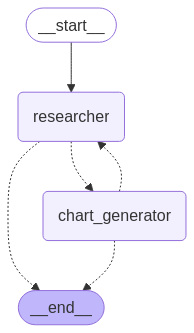

In [49]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({"messages": [("user","give me simple pie chart about india population")]}, {"recursion_limit": 20})